In [90]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping
from keras.layers.merge import concatenate

from math import ceil

import seaborn as sns
sns.set()

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
input_dataset_path = 'drive/MyDrive/Collab-Datasets/nasd_input.csv'
query_dataset_path = 'drive/MyDrive/Collab-Datasets/nasd_query.csv'
DATASET_SIZE = 1
LOOKBACK = 10

In [93]:
timeseries_df = pd.read_csv(input_dataset_path, sep='\t', index_col=0, header=None).astype(np.float32).sample(DATASET_SIZE)
TIME_SERIES_ID = timeseries_df.index.tolist()

In [94]:
def normalize(X, _max, _min):
  return (X - _max)/(_min-_max) 

def reverse_normalize(X, _max, _min):
  return X*(_min-_max) + _max 

def preprocess_timeseries(_timeseries, window=10, normalized=False, _max = None, _min = None):
  if not normalized:
    if _max is None:
      _max = _timeseries.min()
    if _min is None:
      _min = _timeseries.max()

    timeseries = normalize(_timeseries, _max, _min)
  else:
    timeseries = _timeseries
  
  X = None
  for i in range(window, len(timeseries)):
    X_i = np.asarray(timeseries[i-window:i]).reshape((1, len(timeseries[i-window:i]), 1))
    X = np.concatenate((X, X_i)) if X is not None else X_i
    
  return X, _max, _min

In [95]:
window_length = 10
X_all, _max, _min = preprocess_timeseries(timeseries_df.to_numpy()[0], window_length)
print(X_all.shape)
X_train, X_test = train_test_split(X_all, test_size=0.33)

(720, 10, 1)


In [96]:
class TimeSeriesComplexityReducer():
  n_conv_filt_default = 10
  def __init__(self, window_size, conv_layers_setting=[], latent_dim=3, batch_size=64, pool_size=2, verbose=False):
    self.batch_size = batch_size 
    self.verbose=verbose
    
    input_w = layers.Input(shape=(window_size,1))
    input_dim = window_size
    x = input_w
    for conv_settings in conv_layers_setting:
      filters = self.n_conv_filt_default
      if 'filters' in conv_settings:
        filters = conv_settings['filters']
      kernel_size = conv_settings['kernel_size']
      x = layers.Conv1D(filters, kernel_size, padding="same", activation="relu")(x)
      if ceil(input_dim/pool_size) > latent_dim:
        input_dim = ceil(input_dim/pool_size)
        x = layers.MaxPooling1D(pool_size, padding="same")(x)

    # final compression
    compressor_filters = ceil(input_dim / latent_dim)
    compressor_kernel_space = input_dim-latent_dim*compressor_filters + 1
    if compressor_kernel_space > 0:
      x = layers.Conv1D(1, compressor_kernel_space, activation="relu")(x)
      encoded = layers.MaxPooling1D(compressor_filters, padding="same")(x)
    elif compressor_kernel_space < 0:
      compressor_kernel_space = input_dim-latent_dim+1
      encoded = layers.Conv1D(1, input_dim-latent_dim+1, activation="relu")(x)
    else:
      compressor_kernel_space = latent_dim
      x = layers.Conv1D(1, compressor_kernel_space, activation="relu", padding="same")(x)
      encoded = layers.MaxPooling1D(compressor_filters, padding="same")(x)
    
    self.encoder = models.Model(input_w, encoded, name='encoder')
    if self.verbose:
      self.encoder.summary()    

    # decoder model
    output_dim = latent_dim 

    x = layers.Conv1D(1, compressor_kernel_space, activation='relu', padding="same")(encoded)
    if output_dim*pool_size <= window_size:
        output_dim = output_dim*pool_size
        x = layers.UpSampling1D(pool_size)(x)

    for i, conv_settings in enumerate(conv_layers_setting[::-1]):
      padding="same"
      filters = self.n_conv_filt_default
      if 'filters' in conv_settings:
        filters = conv_settings['filters']
      kernel_size = conv_settings['kernel_size']
      
      if i == len(conv_layers_setting)-1:
        # we must treat the final layer differently
        if window_size % pool_size == 0:
          kernel_size = int(output_dim - window_size//pool_size + 1)
          output_dim = window_size//pool_size
          padding="valid"

      x = layers.Conv1D(filters, kernel_size, activation="relu", padding=padding)(x)
      
      if output_dim*pool_size <= window_size:
        output_dim = output_dim*pool_size
        x = layers.UpSampling1D(pool_size)(x)

    decoded = layers.Conv1D(1, latent_dim, activation="sigmoid", padding="same")(x)

    self.autoencoder = models.Model(input_w, decoded, name="autoencoder")
    self.autoencoder.summary()
    self.autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


  def fit(self, X, y, epochs=50):
    self.history = self.autoencoder.fit(X, y,
                epochs=epochs,
                batch_size=self.batch_size,
                shuffle=True,
                validation_split=0.3, 
                verbose=self.verbose)
    return self.history
  def predict(self, X):
    return self.autoencoder.predict(X)

In [103]:
autoencoder = TimeSeriesComplexityReducer(10, [{'filters':16, 'kernel_size':5}, {'filters':16, 'kernel_size':5}], latent_dim=5, verbose=True)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 10, 1)]           0         
                                                                 
 conv1d_112 (Conv1D)         (None, 10, 16)            96        
                                                                 
 conv1d_113 (Conv1D)         (None, 10, 16)            1296      
                                                                 
 conv1d_114 (Conv1D)         (None, 10, 1)             17        
                                                                 
 max_pooling1d_29 (MaxPoolin  (None, 5, 1)             0         
 g1D)                                                            
                                                                 
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________

In [104]:
autoencoder.fit(X_train, X_train, epochs=50)

Epoch 1/50
6/6 [==============================] - 1s 59ms/step - loss: 0.6867 - val_loss: 0.6740
Epoch 2/50
6/6 [==============================] - 0s 11ms/step - loss: 0.6663 - val_loss: 0.6457
Epoch 3/50
6/6 [==============================] - 0s 11ms/step - loss: 0.6342 - val_loss: 0.6057
Epoch 4/50
6/6 [==============================] - 0s 13ms/step - loss: 0.5883 - val_loss: 0.5514
Epoch 5/50
6/6 [==============================] - 0s 12ms/step - loss: 0.5289 - val_loss: 0.4917
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 0.4721 - val_loss: 0.4500
Epoch 7/50
6/6 [==============================] - 0s 15ms/step - loss: 0.4433 - val_loss: 0.4359
Epoch 8/50
6/6 [==============================] - 0s 14ms/step - loss: 0.4347 - val_loss: 0.4300
Epoch 9/50
6/6 [==============================] - 0s 13ms/step - loss: 0.4303 - val_loss: 0.4266
Epoch 10/50
6/6 [==============================] - 0s 13ms/step - loss: 0.4255 - val_loss: 0.4216
Epoch 11/50
6/6 [============

In [105]:
def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, test_samples, 200))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)

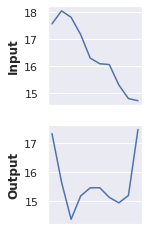

In [106]:
test_samples = 100

plot_examples(reverse_normalize(X_test, _max, _min), reverse_normalize(autoencoder.predict(X_test), _max, _min))

In [101]:
autoencoder.predict(X_test).shape

(238, 10, 1)

In [102]:
X_test.shape

(238, 10, 1)